# Demo de implementación de un algoritmo genérico de Computación Evolutiva (CE) para resolver el problema de encontrar un Máximo Óptimo definido al azar en un plano y tratando de esquivar los máximos locales aleatorios
Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

0) Preparar el ambiente:

In [1]:
#@title
!pip install deap

     |████████████████████████████████| 163kB 8.4MB/s 


1) Importar librerías:

In [2]:
#@title
import random
import math
import numpy as np
import matplotlib.pyplot as plt

from deap import base
from deap import creator
from deap import tools

print("\nLibrerías importadas")


Librerías importadas


2) Establecer parámetros generales de la Corrida:

In [3]:
# Espacio  de búsqueda
CANT_MAXIMOS_LOCALES = 3 #@param {type:"slider", min:0, max:10, step:1}
MIN_ESPACIO_BUSQ = -1000 #@param {type:"slider", min:-1000, max:0, step:10}
MAX_ESPACIO_BUSQ = 1000  #@param {type:"slider", min:0, max:1000, step:10}

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 250 #@param {type:"integer"}

# Cantidad de Individuos en la Población
CANT_INDIVIDUOS_POBLACION = 25  #@param {type:"slider", min:1, max:100, step:1}

# Probabilidad del Cruzamiento (en AG 1 = 100%)
PROBAB_CRUZAMIENTO = 1  #@param {type:"slider", min:0, max:1, step:0.05}

#  Probabilidad del Mutación 
PROBAB_MUTACION = 0.2 #@param {type:"slider", min:0, max:1, step:0.05}

# Indica si se muestra el detalle de las estadísticas en cada ciclo
MUESTRA_ESTADISTICAS = True  #@param {type:"boolean"}

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


2) Inicializar objetos de DEAP para utilizar e indicar Operadores Genéticos:

In [4]:
## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()

## OPERADORES GENÉTICOS
## (ver lista completa en https://deap.readthedocs.io/en/master/api/tools.html#operators )

tipo_seleccion = 'Ranking' #@param ["Azar", "Torneo", "Ranking", "Ruleta", "Control s/Número Esperado"]
tipo_cruzamiento = 'Simple-1Punto' #@param ["Simple-1Punto", "Simple-2Puntos", "Azar"]


# Registrar tipo de Selección a aplicar con sus parámetros
if tipo_seleccion == 'Torneo':
  toolbox.register("select", tools.selTournament, tournsize=2)
elif tipo_seleccion == 'Ranking':
  toolbox.register("select", tools.selBest)
elif tipo_seleccion == 'Ruleta':
  toolbox.register("select", tools.selRoulette)
elif tipo_seleccion == 'Control s/Número Esperado':
  toolbox.register("select", tools.selStochasticUniversalSampling)
else:
  toolbox.register("select", tools.selRandom)

# Registrar tipo de Cruzamiento a aplicar con sus parámetros
if tipo_cruzamiento == 'Simple-1Punto':
  toolbox.register("mate", tools.cxOnePoint)
elif tipo_cruzamiento == 'Simple-2Puntos':
  toolbox.register("mate",  tools.cxTwoPoint)  
else:
  toolbox.register("mate", tools.cxUniform, indpb=0.5)

# Registrar tipo de Mutación a aplicar con sus parámetros
toolbox.register("mutate", tools.mutUniformInt, low=MIN_ESPACIO_BUSQ, up=MAX_ESPACIO_BUSQ, indpb=0.2)

# Registar el operador de Ranking para actualizar la población
toolbox.register("update", tools.selBest) 

print("\nOperadores Genéticos definidos")


Operadores Genéticos definidos


3) Especificar Estructura del Cromosoma y Función de Aptitud:

In [5]:
#@title clase MAPA DE BÚSQUEDA

class MapaBusqueda(object):

    def __init__(self, limMin, limMax, cantMaximosLocales=0):
          self.limMin = limMin
          self.limMax = limMax
          self.cantMax = cantMaximosLocales
          self.generarPosicionesRnd()

    def generarPosicionesRnd(self):
      
        # Define Posiciones Random para Máximos Locales y Óptimos
        # con Heurística también al Azar (entre 1 y 100)
        # controla que el máximo local/global no se ubique en la misma posición que el Hormiguero
        self.MaximosPos = []
        self.MaximosVal = []
        self.MaxOptimoID = 0
        auxMejorVal = -99
        i = 0
        while len(self.MaximosPos)<(self.cantMax+1):

            auxPos = [ random.randint(self.limMin, self.limMax),  random.randint(self.limMin, self.limMax) ]        
            auxVal = random.randint(-20, 100)

            self.MaximosPos.append( auxPos )
            self.MaximosVal.append( auxVal )
            
            if self.MaximosVal[self.MaxOptimoID] < auxVal:
                self.MaxOptimoID = i
            i= i + 1

        return True
   
    def printInformacion(self):
        # Muestra la información sobre el Mapa de Búsqueda
        print("\n** Máximos Generados: ", len(self.MaximosPos))
        for auxPos, auxVal in zip(self.MaximosPos, self.MaximosVal):
            print("  -->", auxPos, "{ ", auxVal, " } ")
        print("\n** Posición Máximo Óptimo: ", self.MaximosPos[self.MaxOptimoID], " { ",  self.MaximosVal[self.MaxOptimoID]," } **")
        print("\n")

    @property
    def posMaximos(self):
        return self.MaximosPos    

    @property
    def valMaximos(self):
        return self.MaximosVal   
        
    @property
    def posMaximoGlobal(self):
        return self.MaximosPos[self.MaxOptimoID]         
    
    @property
    def valMaximoGlobal(self):
        return self.MaximosVal[self.MaxOptimoID]  

    def estaEnMaximo(self, posicion):
      # Indica si la posición corresponde o no a un Máximo 
      # si es verdadero devuelve el valor correspondiente, sino 0
      for i in range(len(self.MaximosPos)):
        if posicion==self.MaximosPos[i]:
          return self.MaximosVal[i]
      return 0

    def funcHeuristica(self, posicion):
        # Define la Función Heurística para evaluar una posicion del mapa
        devuelve = 0
        disPosMenor = self.limMax
        for posMax, valMax in zip(self.MaximosPos, self.MaximosVal):

              # calcula la distancia al punto de la Particula
              sqerrors = ((x - y)**2 for x, y in zip(posicion, posMax))
              distPos =  math.fsum(sqerrors)**0.5 / 10
              
              # Si es la menor distancia calcula la Heurística
              if disPosMenor > distPos:
                  disPosMenor = distPos 
                  devuelve = ( valMax - distPos) 

          # Por las dudas controla que devuelva un valor positivo
        return max(devuelve,0)


print("\nClase Mapa de Búqueda definida") 


Clase Mapa de Búqueda definida


In [6]:
#@title FUNCIÓN DE APTITUD Y  ESTRUCTURA DEL CROMOSOMA

# indica que es la función de aptitud es para maximizar
creator.create("Fitness", base.Fitness, weights=(1.0,))


# Define el Mapa de Búsqueda
mapa = MapaBusqueda(limMin=MIN_ESPACIO_BUSQ, limMax=MAX_ESPACIO_BUSQ, \
                    cantMaximosLocales=CANT_MAXIMOS_LOCALES)

print("\nMapa de búsqueda definido")

# definimos la función de aptitud a evaluar
def funcAptitud(individuo):

    return mapa.funcHeuristica(individuo),
    
# registra la función que se va a evaluar
toolbox.register("evaluate", funcAptitud)

print("\nFunción de Aptitud definida")

# indica que los individuos son una lista de genes que aplica la función antes definida
creator.create("Individual", list, fitness=creator.Fitness)

# indica que los genes son float correspondiente a las posiciones
toolbox.register("attr_int", random.randint, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ) 

# registra el tipo de individuo y población a usar
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

print("\nCromosoma definido")


Mapa de búsqueda definido

Función de Aptitud definida

Cromosoma definido


4) Ejecutar la corrida del algoritmo mostrando resultados:

In [7]:
#@title EJECUCIÓN DE LA CORRIDA


## Define una función auxiliar para calcular estadísticas y guarda info en vectores auxiliares
def CalculoEstadisticas(ciclo, indivPobla, muestra, mejorMax = True):
    
    global mejorIndCorrida
    global ciclosMaxAptitud
    global ciclosPromAptitud
    global ciclosMinAptitud

    if len(indivPobla) == 0:
      return None, 0, 0, 0 

    auxMax = None
    auxMin = None
    auxSum = 0
    auxBestInd = None
    auxBestIndApt = None
    
    for ind in indivPobla:

        apt = round(ind.fitness.values[0], 2)
        auxSum = auxSum + apt

        if (auxMax == None) or (apt > auxMax):
            auxMax = apt
            if mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt

        if (auxMin == None) or (apt < auxMin):
            auxMin = apt
            if not mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt

    auxProm = round(auxSum / len(indivPobla),2)

    if (mejorIndCorrida == None) or (mejorIndCorrida.fitness.values < auxBestInd.fitness.values):
          mejorIndCorrida = auxBestInd
    ciclosMaxAptitud.append( auxMax )
    ciclosPromAptitud.append( auxProm )
    ciclosMinAptitud.append( auxMin )

    if muestra:          
        print("\n-- Ciclo  %i --" % ciclo)
        print(" Mejor Individuo:", auxBestInd, " {", auxBestIndApt, "}")
        print("   Max: ", auxMax, " / Promedio: ", auxProm, " / Min: ", auxMin)

    return auxBestInd, auxMax, auxProm, auxMin


# Muestra su información
mapa.printInformacion()

# Determina mínima Heuristica para finalizar el algoritmo
MIN_HEURISTICA_FINALIZAR = mapa.valMaximoGlobal - 1
print("-- Mínima heurística para finalizar la Corrida: ", MIN_HEURISTICA_FINALIZAR, "--")


# vectores auxiliares 
ciclo = 1    
mejorIndCorrida = None
ciclosIndiv = []
ciclosMaxAptitud = []
ciclosPromAptitud = []
ciclosMinAptitud = []

# Define la población inicial
indivPobla = toolbox.population(n=CANT_INDIVIDUOS_POBLACION)

# Asigna el valor de aptitud a los individuos de la población inicial
fitnesses = list(map(toolbox.evaluate, indivPobla))
for ind, fit in zip(indivPobla, fitnesses):
    ind.fitness.values = fit

ciclosIndiv.append( [] )
ciclosIndiv[0].extend( indivPobla )

# Cálcula estadísticas y guarda info en vectores auxiliares
auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(0, indivPobla, MUESTRA_ESTADISTICAS)

# Finaliza cuando llegue a la cantidad de ciclos 
#     o cuando la heurística del mejor sea mayor a un mínimo
while (ciclo < CANT_CICLOS) \
        and ((mejorIndCorrida==None) or (mejorIndCorrida.fitness.values[0]<MIN_HEURISTICA_FINALIZAR)):

    # Realiza la Selección
    indivSelecc = toolbox.select(indivPobla, len(indivPobla))

    # Inicializa a los hijos clonando a los seleccionados
    indivHijos = list(map(toolbox.clone, indivSelecc))
    
    # Realiza el Cruzamiento
    for hijo1, hijo2 in zip(indivHijos[::2], indivHijos[1::2]):
        if random.random() < PROBAB_CRUZAMIENTO:
            toolbox.mate(hijo1, hijo2)
            del hijo1.fitness.values
            del hijo2.fitness.values
            indivSelecc.append(hijo1)
            indivSelecc.append(hijo2)

    # Realiza la Mutación
    for mutant in indivSelecc:
        if random.random() < PROBAB_MUTACION:
            toolbox.mutate(mutant)
            del mutant.fitness.values
              
    # Evalua a los individuos que salen de la Mutación
    #  para determinar si son válidos y su valor de aptitud
    invalid_ind = [ind for ind in indivSelecc if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    # Actualiza la población tomando nuevamente los mejores con Ranking
    indivPobla.extend(indivSelecc)
    indivPobla[:] = toolbox.update(indivPobla, CANT_INDIVIDUOS_POBLACION)
    ciclosIndiv.append( [] )
    ciclosIndiv[ciclo].extend( indivPobla )
    
    # Cálcula estadísticas y guarda info en vectores auxiliares
    auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(ciclo, indivPobla, MUESTRA_ESTADISTICAS)

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )

print("** Posición Máximo Óptimo a Buscar: ", mapa.posMaximoGlobal, " { ",  mapa.valMaximoGlobal," } **")
print("== Mejor Individuo de la Corrida:", mejorIndCorrida, " { ", mejorIndCorrida.fitness.values[0], " }  ==")


** Máximos Generados:  4
  --> [-146, -553] {  35  } 
  --> [-894, 807] {  16  } 
  --> [327, 639] {  3  } 
  --> [-277, 63] {  30  } 

** Posición Máximo Óptimo:  [-146, -553]  {  35  } **


-- Mínima heurística para finalizar la Corrida:  34 --

-- Ciclo  0 --
 Mejor Individuo: [-431, 135]  { 13.0 }
   Max:  13.0  / Promedio:  0.52  / Min:  0.0

-- Ciclo  1 --
 Mejor Individuo: [-431, 135]  { 13.0 }
   Max:  13.0  / Promedio:  1.04  / Min:  0.0

-- Ciclo  2 --
 Mejor Individuo: [-261, 156]  { 20.56 }
   Max:  20.56  / Promedio:  5.32  / Min:  0.0

-- Ciclo  3 --
 Mejor Individuo: [-82, -649]  { 23.46 }
   Max:  23.46  / Promedio:  14.21  / Min:  10.46

-- Ciclo  4 --
 Mejor Individuo: [-82, -649]  { 23.46 }
   Max:  23.46  / Promedio:  16.55  / Min:  13.0

-- Ciclo  5 --
 Mejor Individuo: [-82, -649]  { 23.46 }
   Max:  23.46  / Promedio:  21.89  / Min:  20.56

-- Ciclo  6 --
 Mejor Individuo: [-82, -649]  { 23.46 }
   Max:  23.46  / Promedio:  23.22  / Min:  22.62

-- Ciclo  7 --
 

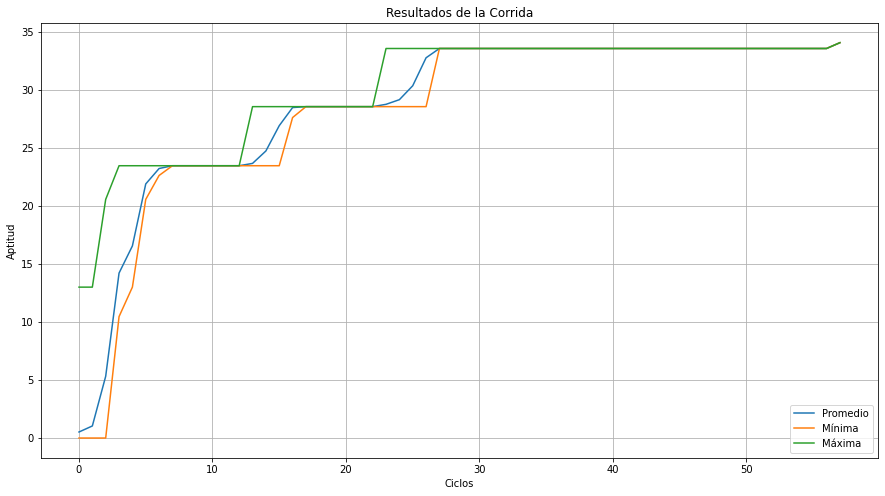

In [8]:
#@title MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8)) 
plt.plot(ciclosPromAptitud)
plt.plot(ciclosMinAptitud)
plt.plot(ciclosMaxAptitud)
plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Aptitud')
plt.legend(['Promedio', 'Mínima', 'Máxima'], loc='lower right')
plt.grid(True)
plt.show()


In [9]:
#@title MOSTRAR GRAFICO DE POSICIONES DE LOS INDIVIDUOS CICLO x CICLO

# Librerías especiales para usar
from matplotlib import animation, rc
from IPython.display import HTML

# Define la configuración para el gráfico
MOSTRAR_HISTORICO_MOVIMIENTO = False
textoTitulo = "Posición de los Individuos del CE ciclo x ciclo"
textoDesc = '\n** Posición Máximo Óptimo a buscar : ' + str(mapa.posMaximoGlobal) + ' { ' +  str(mapa.valMaximoGlobal) +' } **'
textoDesc = textoDesc + '\n== Mejor Individuo de la Corrida: ' + str(mejorIndCorrida) + ' { ' + str(round(mejorIndCorrida.fitness.values[0], 3)) + ' } =='
textoDesc = textoDesc + '\n-- Colores:  Máximos Locales (AZUL) - Máximo Óptimo (VERDE) - '  
textoDesc = textoDesc + '\n- Partículas (ROJO) - Mejor Partícula (VIOLETA) -- ' 
posMejorCorrida =  mejorIndCorrida
ax = None
ani = None

# Método que se ejecuta por cada frame para mostrar 
def updatePlot(i, ciclosPos, scat):

        if ax==None or ciclosPos==None:
            return scat,

        ax.set_xlabel('Ciclo: ' + str(i), fontsize=12)

          # Si no es el último ciclo, muestra también el global
        if i<len(ciclosPos): 
        
          if len(ciclosPos[i])>0:
             
              if MOSTRAR_HISTORICO_MOVIMIENTO:
                  # Coloca nuevas posiciones correspondientes al ciclo
                  # Separa las coordenadas x, y de las posiciones en el ciclo i
                  X, Y = zip(*ciclosPos[i])
                  ## --en Rojo: posiciones de las particulas de cada ciclo
                  scat = ax.scatter(X, Y, color='red')
              else:
                  # Hace mover a las Partículas
                  scat.set_offsets(ciclosPos[i])
        else:
               if posMejorCorrida != None:
                      ## --en Violeta: Mejor posición de las partículas
                      ax.scatter(posMejorCorrida[0], posMejorCorrida[1], color='violet', s=100)

        # Devuelve una lista de "artistas" para dibujar, 
        # en este caso es sólo uno por lo que se pone una coma final
        return scat,    

# Función para preparar el gráfico          
def PrepararGrafico(mapa, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, ciclosPos, textoTitulo="", textoDesc=""):          
      
      fig = plt.figure(figsize=(14,7))
      ax = fig.add_subplot(111)
      plt.close()

      ## -- en Azul: Máximos Locales (positivos)
      ## -- en Cyan: Mínimos Locales (negativos)
      ## -- en Verde: Máximo Óptimo
      for posi, vali in zip(mapa.posMaximos, mapa.valMaximos):    
        if vali < 0:
            ax.scatter(posi[0], posi[1], color='cyan')
        else:
            ax.scatter(posi[0], posi[1], color='blue')
      ax.scatter(mapa.posMaximoGlobal[0], mapa.posMaximoGlobal[1], color='green', s=150)    

      # Define el tamaño de la figura
      ax.axis([MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ])

      # Separa las coordenadas x, y de las posiciones en el ciclo inicial
      X, Y = zip(*ciclosPos[0])
      ## --en Rojo: posiciones de las posiciones de cada ciclo
      scat = ax.scatter(X, Y, color='red')

      # Muestra título y texto debajo
      ax.set_title(textoTitulo)
      ax.set_ylabel(textoDesc, fontsize=11)

      # Luego setea la animación usando los dos métodos anteriores 
      cant = len(ciclosPos)+1
      ani = animation.FuncAnimation(fig, updatePlot, 
                                    frames=cant, interval=cant,
                                    fargs=(ciclosPos, scat), 
                                    blit=True, repeat=False)
      
      return ani, ax
    
# Prepara el gráfico 
ani, ax = PrepararGrafico(mapa, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, ciclosIndiv, textoTitulo, textoDesc)    

# Nota: esto se agega para que funcione en Google Colab
rc('animation', html='jshtml')
ani


In [ ]:
#@title EXPORTA EL GRAFICO ANTERIOR COMO UN VIDEO MP4
from google.colab import files

# Prepara el gráfico 
ani, ax = PrepararGrafico(mapa, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, ciclosIndiv, textoTitulo, textoDesc)    

# Graba el gráfico anterior como un video MP4
nomArchi = "CE Corrida.mp4"
ani.save('/' + nomArchi)
try: 
  files.download('/' + nomArchi)
  print('Video ' + nomArchi + ' generado, debería bajarse automaticamente como un archivo local...')
except ValueError:
  print('Error al intentar descargar el archivo ' + nomArchi)